# Inicjalizacja

In [1]:
import datetime
%matplotlib inline

from evaluator import evaluate, calc_impact, create_functions_in_db
from definitions import Repository
import db
import smells
import metrics
import matplotlib.pyplot as plt
import numpy as np

#plots size in inches
plt.rcParams["figure.figsize"] = (10,5)

In [2]:
# connect with db
db.prepare("postgresql://"+(input("db username [postgres]") or "postgres")+":"+input("db password")+"@"+(input("db host [localhost]") or "localhost")+":"+(input("db port [5432]") or "5432")+"/"+input("db name"))
dbsession = db.get_session()
create_functions_in_db(dbsession)

# Ewaluacja

In [3]:
# select repository
repo = input("repository")

if dbsession.query(Repository).filter(Repository.full_name == repo).first() is None:
    raise LookupError("Repository does not exist")

## Udział smelly prs wśród badanych prs (reprodukcja)

In [4]:
# evaluate for smells
smells_evaluations = [
    evaluate(repo, smells.lack_of_review),
    evaluate(repo, smells.missing_description),
    evaluate(repo, smells.large_changesets),
    evaluate(repo, smells.sleeping_reviews),
    evaluate(repo, smells.review_buddies),
    evaluate(repo, smells.ping_pong),
    evaluate(repo, smells.union,
         [smells.lack_of_review,
          smells.missing_description,
          smells.large_changesets,
          smells.sleeping_reviews,
          smells.review_buddies,
          smells.ping_pong]),
    evaluate(repo, smells.intersection,
         [smells.lack_of_review,
          smells.missing_description,
          smells.large_changesets,
          smells.sleeping_reviews,
          smells.review_buddies,
          smells.ping_pong])
]

In [5]:
# display results as a text
for evaluation in smells_evaluations:
    print(evaluation)

Lack of code review           	93.71%
Missing PR description        	24.04%
Large changeset               	6.07%
Sleeping reviews              	50.79%
Review Buddies                	0.00%
Ping-pong reviews             	0.00%
At least one of:
- lack_of_review              
- missing_description         
- large_changesets            
- sleeping_reviews            
- review_buddies              
- ping_pong                   	98.65%
All of:
- lack_of_review              
- missing_description         
- large_changesets            
- sleeping_reviews            
- review_buddies              
- ping_pong                   	0.00%


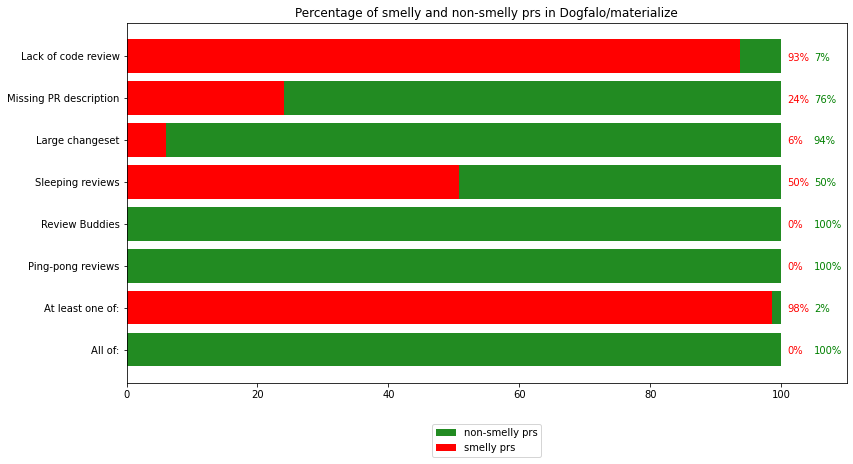

In [6]:
# display results as a plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
xs = list(map(lambda e: e.evaluator_name.split("\n")[0], smells_evaluations))
ys = list(map(lambda e: e.percentage*100, smells_evaluations))
ax.barh(xs, 100, color="forestgreen", label="non-smelly prs")
ax.barh(xs, ys, color="red", label="smelly prs")
for i, v in enumerate(ys):
    ax.text(101, i + 0.1, f"{int(v)}%", color="red")
    ax.text(105, i + 0.1, f"{100-int(v)}%", color="green")
ax.invert_yaxis()
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1))
plt.title(f"Percentage of smelly and non-smelly prs in {repo}")
plt.margins(x=0.1)
plt.show()

## Wpływ smelli na prawdopodobieństwo wprowadzenia błędu

In [7]:
# evaluate for smells impact
impact_evaluations = list(map(lambda pair: (pair[0], calc_impact(session = dbsession,
                                                                 repo = dbsession.query(Repository).filter(Repository.full_name == repo).first(),
                                                                 evaluator = pair[1],
                                                                 evaluator_args=None)), [
    ("Lack of code review", smells.lack_of_review),
    ("Missing PR description", smells.missing_description),
    ("Large changeset", smells.large_changesets),
    ("Sleeping reviews", smells.sleeping_reviews),
    ("Review Buddies", smells.review_buddies),
    ("Ping-pong reviews", smells.ping_pong)
]))

In [8]:
# display results as text
print(
    f"Percentage of pulls where at least one file was changed next by bug solving PR:")
print(f"{''.ljust(30)}OK    \t SMELLY\t IMPACT")

for (name, res) in impact_evaluations:
    print(f"{name.ljust(30)}{(res[0] * 100):.2f}%\t {(res[1] * 100):.2f}%\t {'+' if res[1]>res[0] else ''}{((res[1]-res[0]) * 100):.2f}%")

Percentage of pulls where at least one file was changed next by bug solving PR:
                              OK    	 SMELLY	 IMPACT
Lack of code review           60.71%	 58.99%	 -1.72%
Missing PR description        60.36%	 55.14%	 -5.21%
Large changeset               57.66%	 81.48%	 +23.83%
Sleeping reviews              57.53%	 60.62%	 +3.09%
Review Buddies                59.10%	 nan%	 nan%
Ping-pong reviews             59.10%	 nan%	 nan%


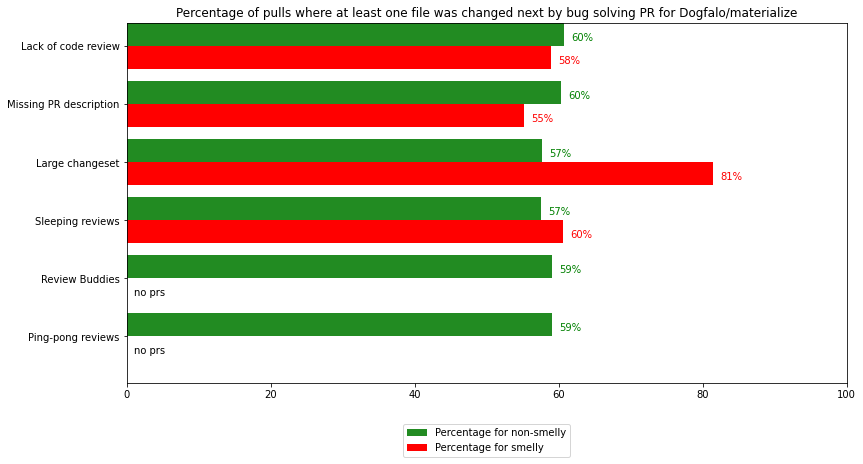

In [9]:
# display results as a plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
xs = list(map(lambda e: e[0], impact_evaluations))
for_ok = list(map(lambda e: e[1][0]*100, impact_evaluations))
for_smelly = list(map(lambda e: e[1][1]*100, impact_evaluations))
ind = np.arange(len(xs))
width = 0.4

ax.barh(ind, for_ok, width, color="forestgreen", label="Percentage for non-smelly")
for i, v in enumerate(for_ok):
    ax.text((v + 1 if v<95 else 95) if v==v else 1, i + 0.1, f"{int(v)}%" if v==v else "no prs",  color=("green" if v<95 else "black"))
ax.barh(ind + width, for_smelly, width, color="red", label="Percentage for smelly")
for i, v in enumerate(for_smelly):
    ax.text((v + 1 if v<95 else 95) if v==v else 1, i + width + 0.1, f"{int(v)}%" if v==v else "no prs", color=("red" if v<95 else "black"))
ax.set(yticks=ind + width/2, yticklabels=xs, ylim=[2*width-1, len(xs)], xlim=[0, 100])
ax.invert_yaxis()
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1))
plt.title(f"Percentage of pulls where at least one file was changed next by bug solving PR for {repo}")
plt.show()

## Metryki

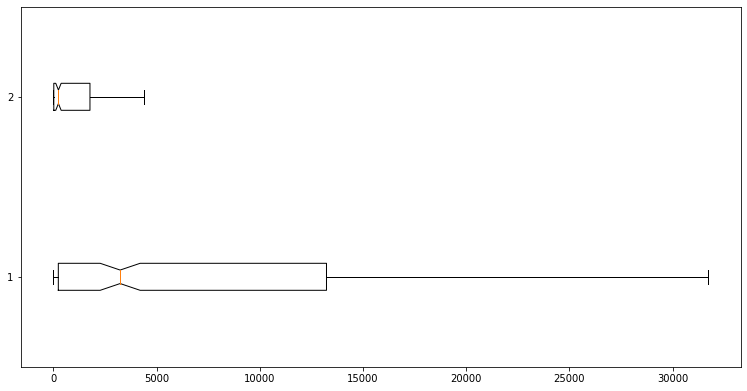

<Figure size 1440x720 with 0 Axes>

[348.0, 19632.0, 0.0, 34.0, 0.0, 5.0, 166.0, 64.0, 263.0, 0.0, 121.0, 159.0, 20.0, 919.0, 2.0, 122.0, 5.0, 4350.0, 6.0, 0.0, 0.0, 572.0, 36.0, 79.0, 167.0, 47.0, 97.0, 1417.0, 1142.0, 20.0, 713.0, 12171.0, 192.0, 2409.0, 1.0, 2.0, 9.0, 264.0, 0.0, 12061.0, 20.0, 0.0, 14532.0, 337.0, 549.0, 10307.0, 752.0, 133.0, 4458.0, 559.0, 4555.0, 1812.0, 107257.0, 7711.0, 9536.0, 2.0, 4734.0, 14394.0, 1222.0, 4385.0, 7854.0, 4587.0, 358.0, 167.0, 120.0, 853.0, 30871.0, 3257.0, 343.0, 5733.0, 793.0, 6.0, 187.0, 9047.0, 1474.0, 1342.0, 572.0, 346.0, 27623.0, 1.0, 26784.0, 25824.0, 8068.0, 13720.0, 80.0, 4038.0, 1.0, 82.0, 9982.0, 1.0, 135.0, 815.0, 13233.0, 4515.0, 3710.0, 2277.0, 3525.0, 17.0, 0.0, 21733.0, 304383.0, 249.0, 4267.0, 1.0, 1217.0, 61.0, 3238.0, 9672.0, 1.0, 5.0, 33.0, 14.0, 6064.0, 2909.0, 2876.0, 11279.0, 26188.0, 419.0, 69059.0, 7083.0, 4876.0, 18479.0, 519.0, 56357.0, 272.0, 3358.0, 713.0, 10538.0, 19657.0, 19402.0, 2180.0, 3575.0, 64.0, 9067.0, 5511.0, 36164.0, 6950.0, 4670.0, 356

In [10]:
from sqlalchemy import column, select
from evaluator import get_considered_prs

repo_obj = dbsession.query(Repository).filter(Repository.full_name == repo).first()
prs = get_considered_prs(session = dbsession, repo = repo_obj)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.boxplot([
    metrics.review_window_metric(prs, repo_obj).to_list(dbsession),
    metrics.review_window_per_line_metric(prs, repo_obj).to_list(dbsession)],
    showfliers=False, notch=True, vert=False)
plt.figure(figsize=(20,10))
plt.show()

#print(metrics.review_window_metric(prs,repo_obj).to_list(dbsession))

In [ ]:
# display results as a text
for evaluation in smells_evaluations:
    print(evaluation)

In [ ]:
# display results as a plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
xs = list(map(lambda e: e.evaluator_name.split("\n")[0], smells_evaluations))
ys = list(map(lambda e: e.percentage*100, smells_evaluations))
ax.barh(xs, 100, color="forestgreen", label="non-smelly prs")
ax.barh(xs, ys, color="red", label="smelly prs")
for i, v in enumerate(ys):
    ax.text(101, i + 0.1, f"{int(v)}%", color="red")
    ax.text(105, i + 0.1, f"{100-int(v)}%", color="green")
ax.invert_yaxis()
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1))
plt.title(f"Percentage of smelly and non-smelly prs in {repo}")
plt.margins(x=0.1)
plt.show()

## Wpływ smelli na prawdopodobieństwo wprowadzenia błędu

In [7]:
# evaluate for smells impact
impact_evaluations = list(map(lambda pair: (pair[0], calc_impact(session = dbsession,
                                                                 repo = dbsession.query(Repository).filter(Repository.full_name == repo).first(),
                                                                 evaluator = pair[1],
                                                                 evaluator_args=None)), [
    ("Lack of code review", smells.lack_of_review),
    ("Missing PR description", smells.missing_description),
    ("Large changeset", smells.large_changesets),
    ("Sleeping reviews", smells.sleeping_reviews),
    ("Review Buddies", smells.review_buddies),
    ("Ping-pong reviews", smells.ping_pong)
]))

In [ ]:
# display results as text
print(
    f"Percentage of pulls where at least one file was changed next by bug solving PR:")
print(f"{''.ljust(30)}OK    \t SMELLY\t IMPACT")

for (name, res) in impact_evaluations:
    print(f"{name.ljust(30)}{(res[0] * 100):.2f}%\t {(res[1] * 100):.2f}%\t {'+' if res[1]>res[0] else ''}{((res[1]-res[0]) * 100):.2f}%")

In [ ]:
# display results as a plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
xs = list(map(lambda e: e[0], impact_evaluations))
for_ok = list(map(lambda e: e[1][0]*100, impact_evaluations))
for_smelly = list(map(lambda e: e[1][1]*100, impact_evaluations))
ind = np.arange(len(xs))
width = 0.4

ax.barh(ind, for_ok, width, color="forestgreen", label="Percentage for non-smelly")
for i, v in enumerate(for_ok):
    ax.text((v + 1 if v<95 else 95) if v==v else 1, i + 0.1, f"{int(v)}%" if v==v else "no prs",  color=("green" if v<95 else "black"))
ax.barh(ind + width, for_smelly, width, color="red", label="Percentage for smelly")
for i, v in enumerate(for_smelly):
    ax.text((v + 1 if v<95 else 95) if v==v else 1, i + width + 0.1, f"{int(v)}%" if v==v else "no prs", color=("red" if v<95 else "black"))
ax.set(yticks=ind + width/2, yticklabels=xs, ylim=[2*width-1, len(xs)], xlim=[0, 100])
ax.invert_yaxis()
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1))
plt.title(f"Percentage of pulls where at least one file was changed next by bug solving PR for {repo}")
plt.show()

## Metryki

In [ ]:
from sqlalchemy import column, select
from evaluator import get_considered_prs

repo_obj = dbsession.query(Repository).filter(Repository.full_name == repo).first()
prs = get_considered_prs(session = dbsession, repo = repo_obj)

def get_metric_res_as_list(metric: callable):
    result = metric(prs, repo_obj)
    return list(map(lambda r: float(r[0]),dbsession.execute(select(column(result.metrics_names[0])).select_from(result.evaluated.subquery())).all()))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.boxplot([get_metric_res_as_list(metrics.review_window_metric),get_metric_res_as_list(metrics.review_window_per_line_metric)], showfliers=False, notch=True, vert=False)
plt.figure(figsize=(20,10))
plt.show()